<a href="https://colab.research.google.com/github/JoDeMiro/Keras/blob/main/06_Keras_Regression_for_Image_Multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Bevezetés a TensorFlow regresszió használatába.

Nem utolsó sorban azért készítem el ezt a notebookot mert elképesztően jó template.

In [ ]:
#@title Leírás
# Ha valamilyen regresszó jellegű problémát szeretnél megoldani.
# Ami azt jelenti, hogy a bemeneti és a kimeneti válozó is folytonos, nem kategóriális.
#
# https://www.github.com
#
# Ez a kis program a regressziós problémák megoldásába nyújt bevezetést.
# Egyébként ez a kód a TensorFlow honlapjáról származik.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic regression: Image(z) -> Image(x,y)

<table class="buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/JoDeMiro/Face" /><img src="https://github.com/JoDeMiro/Data/raw/main/Bucket/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Ebben a példában csak próba képpen szeretném megvizsgálni és ezen keresztül jobban megérteni a Keras API működését. *Példában* egy kép Pixel(z) értékeit fogom becsülni a Image(x,y) értékei alapján.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.7.0


In [ ]:
from keras import backend as K

if K.backend() == "tensorflow":
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name == '':
        device_name = "None"
    print('Using TensorFlow version:', tf.__version__, ', GPU:', device_name)

Using TensorFlow version: 2.7.0 , GPU: /device:GPU:0


In [10]:
import cv2
import imutils
from google.colab.patches import cv2_imshow

## Import one image

Egy konkrét képen fogom megvizsgálni a modelt. Ehhez le kell tölteni egy képet. A GitHub repositoriumban van egy külön projektem ahol a letöltehtő adatokat helyeztem el. [GitHub](https://github.com/JoDeMiro/Data).


### Get the data
Elöször töltsük le és importáljuk be az adatokat Imutils segítségével:

In [7]:
%%capture
!wget https://github.com/JoDeMiro/Data/raw/main/Images/woman1.png
!wget https://github.com/JoDeMiro/Data/raw/main/Images/woman2.png


### Upload data

Ha valamiért úgy döntenék, hogy inkább fel akarok tölteni adatokat a saját gépemről akkor azt az alábbi paranccsal tudom a legkönnyebben kódból megteni. Egyébként hasznos, de azért nem szeretem ezt a megoldást, mert az outputra teszi feltöltött képet byte forában és feleslegesen nagy és olvashatatlan outputot eredményez. Ez a megoldás csak a **Google Colab** alatt működik.

In [2]:
# from google.colab import files

# uploaded = files.upload()

# for filename in uploaded.keys():
#     print(uploaded[filename])


### Convert image to NumPy Array

Átkonvertálom a képet NumPy formába:

images.shape = (196, 300, 3)
rgb.shape    = (196, 300, 3)
gray.shape   = (196, 300)


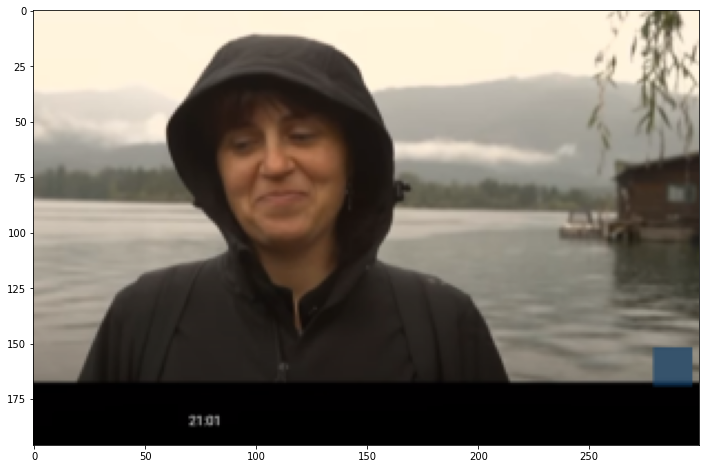

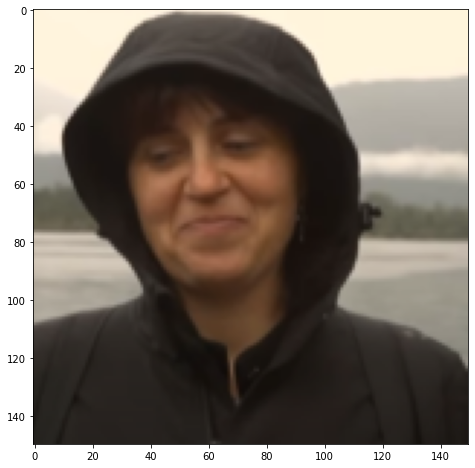

In [11]:
def read_and_resize_the_image(filename, width):

  image = cv2.imread(filename)
  image = imutils.resize(image, width=width)
  rgb   = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  gray  = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  print('images.shape =', image.shape)
  print('rgb.shape    =', rgb.shape)
  print('gray.shape   =', gray.shape)

  return rgb, gray

def show_images(array):
  plt.figure(figsize=(14, 8))
  plt.imshow(array)
  plt.show()

def crop_converted_image(rgb, gray, x, y, width, height):
  croped_rgb = rgb.copy()
  croped_gray = gray.copy()
  croped_rgb = croped_rgb[y:y+height, x:x+width, :]
  croped_gray = croped_gray[y:y+height, x:x+width]
  return croped_rgb, croped_gray


# ---------------------->
filename = './woman1.png'

rgb, gray = read_and_resize_the_image(filename, width=300)

show_images(rgb)

croped_rgb, croped_gray = crop_converted_image(rgb, gray, 50, 10, 150, 150)

show_images(croped_rgb)


Át kell alakítanunk a képet amely jelenleg 2D illetve 3D tömb (gray, rgb) olyan formába, hogy az adatokat be tudjuk vinni egy olyan modelbe ahol $Image(PixelValue_{ij}) = Image(XCordinate_i,YCordinate_j)$

In [12]:
# turn image matrix into vector


flattened = croped_gray.flatten()
flattened.shape

print('gray.shape', croped_gray.shape)
print('flatened.shape', flattened.shape)


# create and add to pandas datafram -> egyébként szükségtelen
data = pd.DataFrame(flattened, columns=['pixels'])
# data.head()

gray.shape (150, 150)
flatened.shape (22500,)


Meg kell csinálni, hozzá az x és az y koordinátákat tartalmazó NumPy tömböket is.

Ami itt nagyon fontos:


```
A NumPy.shape visszatérési értéke (sorok, oszlopok)

A .flatten elvileg sor priority, de paraméterként meg lehet neki adni, hogy oszlop priority legyen

a = np.array([[1,2,3], [4,5,6], [7,8,9]])
print('a.shape', a.shape)
a.shape (3, 3)

b = a.flatten()
print('b.shape', b.shape)
b.shape (9,)

c = a.flatten(order='F')
print('c.shape', c.shape)
c.shape (9,)

print(b)
[1 2 3 4 5 6 7 8 9]

print(c)
[1 4 7 2 5 8 3 6 9]
```

Ez azt jelenti, hogy amikor megcsináljuk az új x, y változókat, akkor a következő képpen kell eljáni.

```
Ha x -> oszlopok
És y -> sorok

akkor y -> [0, 1, 2, 3, ..., 0, 1, 2, 3, ..]
és    x -> [0, 0, 0, 0, ..., 1, 1, 1, 1, ..]
```


In [13]:
def create_xy_coordinate_for_gray_array(gray):
  image_height_rows = gray.shape[0]
  image_width_cols  = gray.shape[1]
  print('image_height_rows', image_height_rows)
  print('image_width_cols ', image_width_cols)
  pixels = gray.flatten(order='C')    # 'C' = Rows then Cols
  size = gray.size
  _x_tmp  = np.arange(start=0, stop=image_width_cols, step=1)       # [0, 1, 2, ..., image_width_cols]
  image_width_cols_x = np.repeat(_x_tmp, image_height_rows)         # annyi ilyet csinál ahány sor van
  # > [0, 0, 0, ..., 1, 1, 1, ..., 2, 2, 2, ...]
  _y_tmp  = np.arange(start=0, stop=image_height_rows, step=1)      # [0, 1, 2, ..., image_height_rows]
  image_height_rows_y = np.tile(_y_tmp, image_width_cols)           # annyi ilyet csinál ahány oszlop van
  # > [1, 2, 3, ..., 1, 2, 3, ..., 1, 2, 3, ...]

  return pixels, image_height_rows_y, image_width_cols_x            # z, y(rows, height), x(cols, width)



In [14]:
z, y, x = create_xy_coordinate_for_gray_array(croped_gray)

image_height_rows 150
image_width_cols  150


In [15]:
input  = np.array([x,y]).T
output = np.array([z]).T

input  = input.copy() / 150.0                   # kiváncsi vagyok milyen amikor noralizálom és és milyen amikor nem
output = output.copy() / 255.0                  # az output változót is normalizálni kell

print(input.shape)
print(output.shape)

n_inputs, n_outputs = input.shape[1], output.shape[1]

(22500, 2)
(22500, 1)


In [16]:
import keras

first_layer_neurons = 100
second_layer_neurons = 100
activation_function = 'relu'      #--------> 'relu', 'sigmoid', 'selu' -----> https://keras.io/api/layers/activations/
loss_function = 'mse'             #--------> 'mse', 'mae'              -----> https://keras.io/api/losses/regression_losses/

# define the model
model = keras.Sequential()
# --------> first input layer
# model.add(keras.layers.Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))  # Valahány bemenet
model.add(keras.layers.Dense(first_layer_neurons, input_dim=2, activation=activation_function))           # Két bemenet
# --------> second hidden layer
model.add(keras.layers.Dense(second_layer_neurons, activation=activation_function))         # Csak a neuronok számát adom meg
# --------> second hidden layer
model.add(keras.layers.Dense(second_layer_neurons, activation=activation_function))         # Csak a neuronok számát adom meg
# --------> last output layer
# model.add(keras.layers.Dense(n_outputs))              # Valahány kimenet
model.add(keras.layers.Dense(1))                        # Egy kimenet
model.compile(loss=loss_function, optimizer='adam')     # Mean absolute error a hibafüggvény ---------> https://keras.io/api/losses/regression_losses/

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               300       
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 20,601
Trainable params: 20,601
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(input, output, verbose=1, batch_size = 32, epochs=100) # ------> batch_size = 32 (default)

# evaluate model on test set
# loss = model.evaluate(input, output, verbose=0)

# print result
# print('>%.3f' % loss)

Epoch 1/100
704/704 [==============================] - 5s 3ms/step - loss: 0.0346
Epoch 2/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0182
Epoch 3/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0121
Epoch 4/100
704/704 [==============================] - 3s 4ms/step - loss: 0.0092
Epoch 5/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0079
Epoch 6/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0067
Epoch 7/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0059
Epoch 8/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0058
Epoch 9/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0052
Epoch 10/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0053
Epoch 11/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0046
Epoch 12/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0045
Epoch 13/100


In [18]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

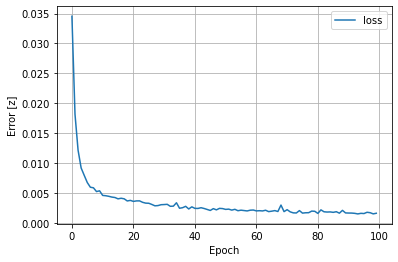

In [19]:
plot_loss(history)

In [20]:
y_predicted = model.predict(input)

In [21]:
y_predicted[0:10]

array([[0.963],
       [0.965],
       [0.966],
       [0.966],
       [0.967],
       [0.967],
       [0.966],
       [0.966],
       [0.966],
       [0.965]], dtype=float32)

In [22]:
y_predicted_retransformed = y_predicted.reshape((croped_gray.shape[0], croped_gray.shape[1]))

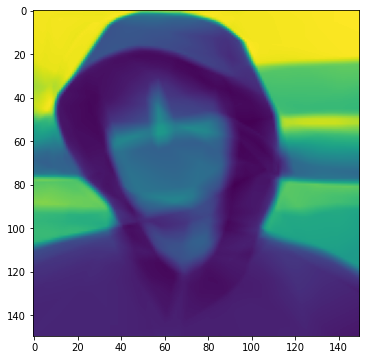

In [23]:
plt.figure(figsize=(6,6))
plt.imshow(y_predicted_retransformed)
plt.show()

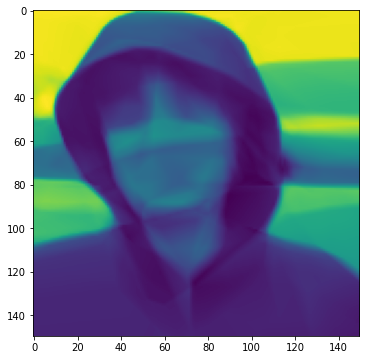

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(y_predicted_retransformed)
plt.show()

## Na jó

Akkor most ugyan ez Functional API segítségével

In [26]:
import keras
import tensorflow as tf

bemenet = 2
kimenet = 1

activation = 'tanh'

neural_net_inputs = tf.keras.Input(shape=(bemenet,))
dense_layer_1     = tf.keras.layers.Dense(units=20, activation=activation)(neural_net_inputs)
dense_layer_2     = tf.keras.layers.Dense(units=20, activation=activation)(dense_layer_1)
output_layer      = tf.keras.layers.Dense(units=kimenet)(dense_layer_2)

model             = tf.keras.Model(inputs=neural_net_inputs, outputs=output_layer)

model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 20)                60        
                                                                 
 dense_5 (Dense)             (None, 20)                420       
                                                                 
 dense_6 (Dense)             (None, 1)                 21        
                                                                 
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = model.fit(x=input, y=output, verbose=0, epochs=100, batch_size=64)

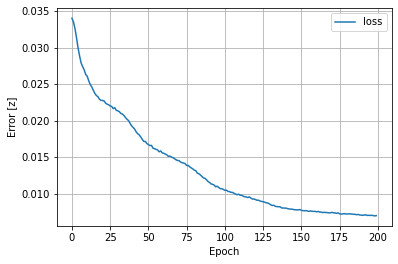

In [34]:
plot_loss(history)

In [35]:
y_predicted = model.predict(input)

y_predicted_retransformed = y_predicted.reshape((croped_gray.shape[0], croped_gray.shape[1]))

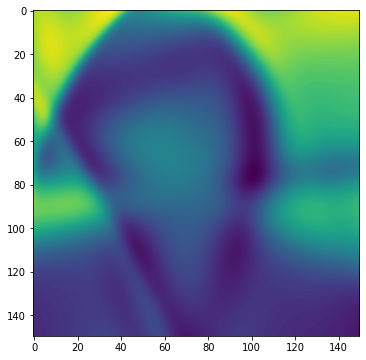

In [36]:
plt.figure(figsize=(6,6))
plt.imshow(y_predicted_retransformed)
plt.show()

## Na jó

Akkor most két külön hálón tanítom a két bemenetet

In [49]:
input_1 = tf.keras.Input(shape=(1,))
input_2 = tf.keras.Input(shape=(1,))

m1_dense_layer_1     = tf.keras.layers.Dense(units=100, activation=activation)(input_1)
m1_dense_layer_2     = tf.keras.layers.Dense(units=100, activation=activation)(m1_dense_layer_1)

m2_dense_layer_1     = tf.keras.layers.Dense(units=100, activation=activation)(input_2)
m2_dense_layer_2     = tf.keras.layers.Dense(units=100, activation=activation)(m2_dense_layer_1)

kimenet = 1

concat_layer         = tf.keras.layers.Concatenate()([m1_dense_layer_2, m2_dense_layer_2])
dense_layer_3        = tf.keras.layers.Dense(200, activation=activation)(concat_layer)
output_layer         = tf.keras.layers.Dense(kimenet)(dense_layer_3)

model                = tf.keras.Model(inputs=[input_1, input_2], outputs=output_layer)

model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_13 (Dense)               (None, 100)          200         ['input_4[0][0]']                
                                                                                                  
 dense_15 (Dense)               (None, 100)          200         ['input_5[0][0]']                
                                                                                            

In [38]:
input_var_1 = input[:,0]
input_var_2 = input[:,1]
output_var  = output

In [73]:
history = model.fit(x=[input_var_1, input_var_2], y=output_var, verbose=1, epochs=10, batch_size=input_var_1.size) # ------> batch_size = 32 (default)

Epoch 1/10
1/1 [==============================] - 0s 461ms/step - loss: 0.1811
Epoch 2/10
1/1 [==============================] - 0s 17ms/step - loss: 0.1129
Epoch 3/10
1/1 [==============================] - 0s 16ms/step - loss: 0.1419
Epoch 4/10
1/1 [==============================] - 0s 20ms/step - loss: 0.1382
Epoch 5/10
1/1 [==============================] - 0s 28ms/step - loss: 0.1122
Epoch 6/10
1/1 [==============================] - 0s 17ms/step - loss: 0.0968
Epoch 7/10
1/1 [==============================] - 0s 19ms/step - loss: 0.1000
Epoch 8/10
1/1 [==============================] - 0s 21ms/step - loss: 0.1075
Epoch 9/10
1/1 [==============================] - 0s 21ms/step - loss: 0.1056
Epoch 10/10
1/1 [==============================] - 0s 23ms/step - loss: 0.0957


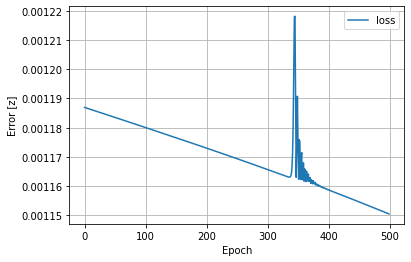

In [68]:
plot_loss(history)

In [69]:
y_predicted = model.predict([input_var_1, input_var_2])

y_predicted_retransformed = y_predicted.reshape((croped_gray.shape[0], croped_gray.shape[1]))

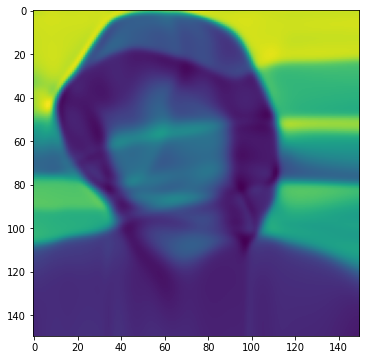

In [70]:
plt.figure(figsize=(6,6))
plt.imshow(y_predicted_retransformed)
plt.show()

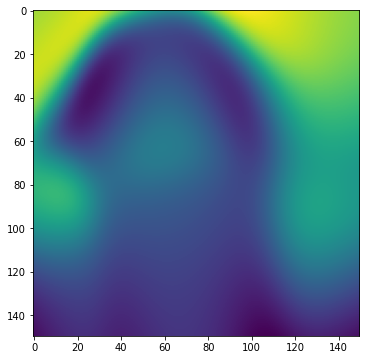

In [44]:
plt.figure(figsize=(6,6))
plt.imshow(y_predicted_retransformed)
plt.show()

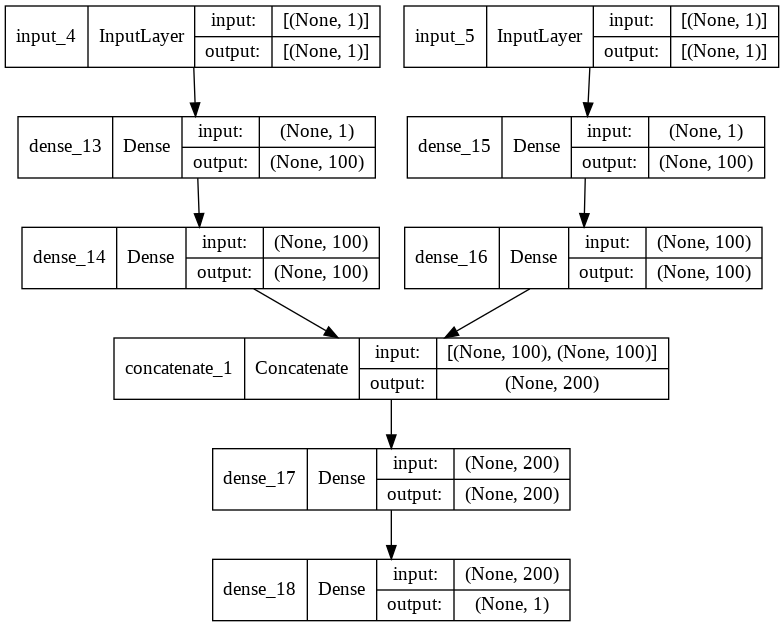

In [71]:
# from tensorflow.keras.utils import plot_model

tf.keras.utils.plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

## Na jó

Egy kissebb architektúrával

In [77]:
input_1 = tf.keras.Input(shape=(1,))
input_2 = tf.keras.Input(shape=(1,))

activation = 'relu'

m1_dense_layer_1     = tf.keras.layers.Dense(units=200, activation=activation)(input_1)
# m1_dense_layer_2     = tf.keras.layers.Dense(units=100, activation=activation)(m1_dense_layer_1)

m2_dense_layer_1     = tf.keras.layers.Dense(units=200, activation=activation)(input_2)
# m2_dense_layer_2     = tf.keras.layers.Dense(units=100, activation=activation)(m2_dense_layer_1)

kimenet = 1

concat_layer         = tf.keras.layers.Concatenate()([m1_dense_layer_1, m2_dense_layer_1])
dense_layer_3        = tf.keras.layers.Dense(200, activation=activation)(concat_layer)
dense_layer_4        = tf.keras.layers.Dense(200, activation=activation)(dense_layer_3)
output_layer         = tf.keras.layers.Dense(kimenet)(dense_layer_4)

model                = tf.keras.Model(inputs=[input_1, input_2], outputs=output_layer)

model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_23 (Dense)               (None, 200)          400         ['input_8[0][0]']                
                                                                                                  
 dense_24 (Dense)               (None, 200)          400         ['input_9[0][0]']                
                                                                                            

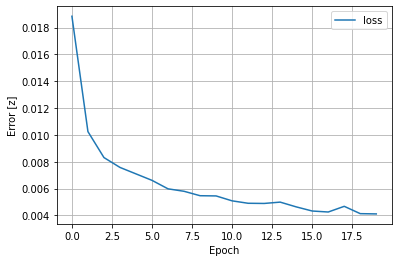

In [93]:
history = model.fit(x=[input_var_1, input_var_2], y=output_var, verbose=0, epochs=20, batch_size=20) # ------> batch_size = 32 (default)

plot_loss(history)

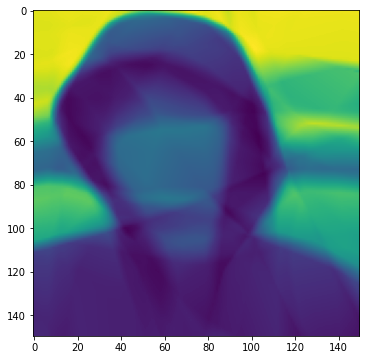

In [94]:
y_predicted = model.predict([input_var_1, input_var_2])

y_predicted_retransformed = y_predicted.reshape((croped_gray.shape[0], croped_gray.shape[1]))

plt.figure(figsize=(6,6))
plt.imshow(y_predicted_retransformed)
plt.show()

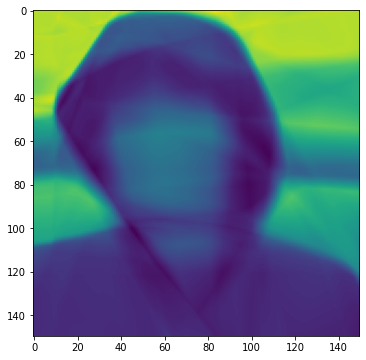

In [87]:
y_predicted = model.predict([input_var_1, input_var_2])

y_predicted_retransformed = y_predicted.reshape((croped_gray.shape[0], croped_gray.shape[1]))

plt.figure(figsize=(6,6))
plt.imshow(y_predicted_retransformed)
plt.show()

## Na jó

Ez a concatenate megoldás nem sikerült valami jól, de szeretném megörizni a Funcitonal API előenyit ezért most csinálok egy egyszerűbb modelt a Funcitonal API segítségével.

In [102]:
input_layer = tf.keras.Input(shape=(2,))

activation = 'relu'
kimenet = 1

dense_layer_1     = tf.keras.layers.Dense(units=400, activation=activation)(input_layer)
dense_layer_2     = tf.keras.layers.Dense(units=500, activation=activation)(dense_layer_1)
output_layer      = tf.keras.layers.Dense(kimenet)(dense_layer_2)

model             = tf.keras.Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_31 (Dense)            (None, 400)               1200      
                                                                 
 dense_32 (Dense)            (None, 500)               200500    
                                                                 
 dense_33 (Dense)            (None, 1)                 501       
                                                                 
Total params: 202,201
Trainable params: 202,201
Non-trainable params: 0
_________________________________________________________________


In [103]:
input_var  = input
output_var = output

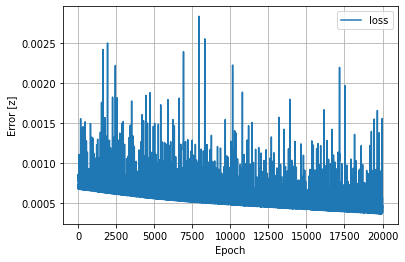

In [110]:
history = model.fit(x=input_var, y=output_var, verbose=0, epochs=20000, batch_size=input_var.size) # ------> batch_size = 32 (default)

plot_loss(history)

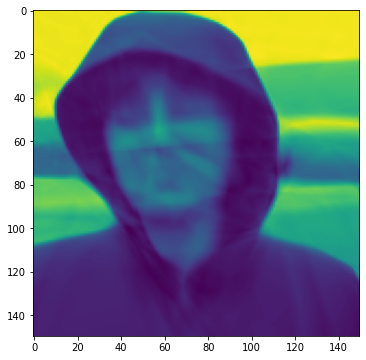

In [111]:
y_predicted = model.predict(input_var)

y_predicted_retransformed = y_predicted.reshape((croped_gray.shape[0], croped_gray.shape[1]))

plt.figure(figsize=(6,6))
plt.imshow(y_predicted_retransformed)
plt.show()

## Na jó

Akkor most ugyan ezt de úgy, hogy Gray helyett az RGB képet becsülöm és úgy, hogy mindhárom csatornát külön külön. Kíváncsi leszek az eredményre.

In [ ]:
croped_rgb.shape

(150, 150, 3)

In [ ]:
# Extract chanels
red = croped_rgb[:,:,0]
green = croped_rgb[:,:,1]
blue = croped_rgb[:,:,2]

# Flatten chanels
red_flattened = red.flatten()
green_flattened = green.flatten()
blue_flattened = blue.flatten()

# Stack them together
output = np.array([red_flattened, green_flattened, blue_flattened]).T

# Normalizálom őket
output = output.copy() / 255.0                  # az output változót is normalizálni kell

# Check
output.shape


(22500, 3)

In [ ]:
# Előállítom az X, Y változókat

_, y, x = create_xy_coordinate_for_gray_array(croped_gray)

input  = np.array([x,y]).T
input  = input.copy() / 150.0                   # kiváncsi vagyok milyen amikor noralizálom és és milyen amikor nem

print(input.shape)
print(output.shape)

n_inputs, n_outputs = input.shape[1], output.shape[1]

image_height_rows 150
image_width_cols  150
(22500, 2)
(22500, 3)


In [ ]:
# Ugyan azt a modelt fogom használni mint előbb, csak most három kimenettel


import keras

first_layer_neurons = 100
second_layer_neurons = 100
activation_function = 'relu'      #--------> 'relu', 'sigmoid', 'selu' -----> https://keras.io/api/layers/activations/
loss_function = 'mse'             #--------> 'mse', 'mae'              -----> https://keras.io/api/losses/regression_losses/

# define the model
model = keras.Sequential()
# --------> first input layer
# model.add(keras.layers.Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))  # Valahány bemenet
model.add(keras.layers.Dense(first_layer_neurons, input_dim=2, activation=activation_function))           # Két bemenet
# --------> second hidden layer
model.add(keras.layers.Dense(second_layer_neurons, activation=activation_function))         # Csak a neuronok számát adom meg
# --------> second hidden layer
model.add(keras.layers.Dense(second_layer_neurons, activation=activation_function))         # Csak a neuronok számát adom meg
# --------> last output layer
# model.add(keras.layers.Dense(n_outputs))              # Valahány kimenet
model.add(keras.layers.Dense(3))                        # Három kimenet
model.compile(loss=loss_function, optimizer='adam')     # Mean absolute error a hibafüggvény ---------> https://keras.io/api/losses/regression_losses/

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 100)               300       
                                                                 
 dense_36 (Dense)            (None, 100)               10100     
                                                                 
 dense_37 (Dense)            (None, 100)               10100     
                                                                 
 dense_38 (Dense)            (None, 3)                 303       
                                                                 
Total params: 20,803
Trainable params: 20,803
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# https://en.wikipedia.org/wiki/Stochastic_gradient_descent

# arra az esetre, ha meg akarok őrülni

In [ ]:
# https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/

# ez is olyan ami alapján lehet cikket írni, alapanyag

In [ ]:

# https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/


# olvastam egy sexy cikket
# a batch_size jelentőségéről

# van ahol a batch size nagyon kicsi (n=1 -> sgd), de van olyan is, hogy teljes mintát odaadja neki

In [ ]:

history = model.fit(input, output, verbose=0, batch_size = input.size, epochs=60000) # ------> batch_size = 32 (default)


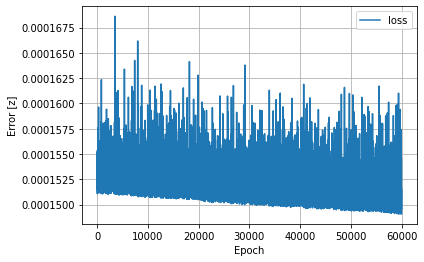

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [ ]:
y_predicted = model.predict(input)

y_predicted[0:10]

array([[1.   , 0.961, 0.873],
       [0.998, 0.96 , 0.873],
       [0.997, 0.96 , 0.872],
       [0.997, 0.96 , 0.872],
       [0.997, 0.96 , 0.872],
       [0.997, 0.96 , 0.872],
       [0.997, 0.96 , 0.873],
       [0.997, 0.96 , 0.873],
       [0.997, 0.96 , 0.873],
       [0.997, 0.961, 0.873]], dtype=float32)

In [ ]:
y_predicted_retransformed = y_predicted.reshape((croped_rgb.shape[0], croped_rgb.shape[1], 3))

y_predicted_retransformed.shape

(150, 150, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


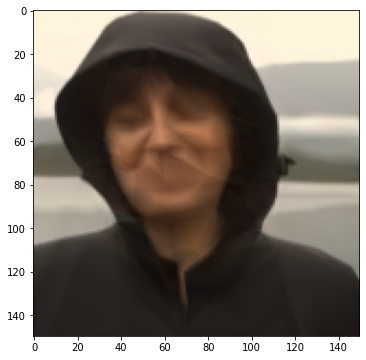

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(y_predicted_retransformed)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


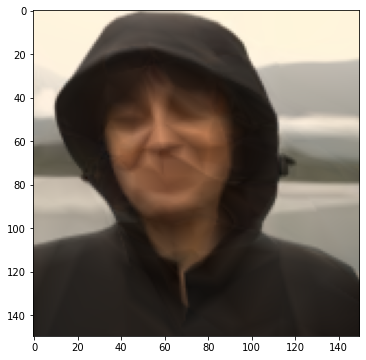

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(y_predicted_retransformed)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


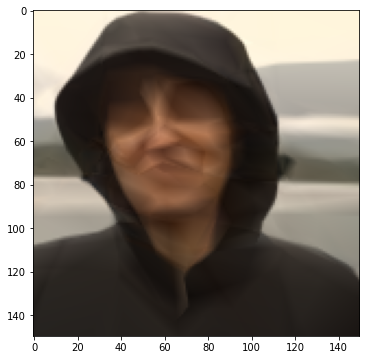

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(y_predicted_retransformed)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


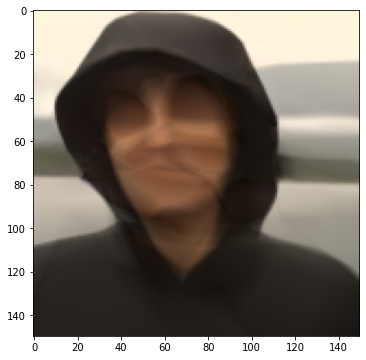

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(y_predicted_retransformed)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


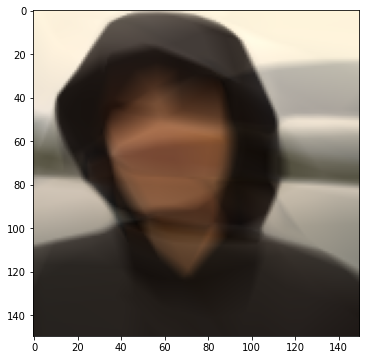

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(y_predicted_retransformed)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


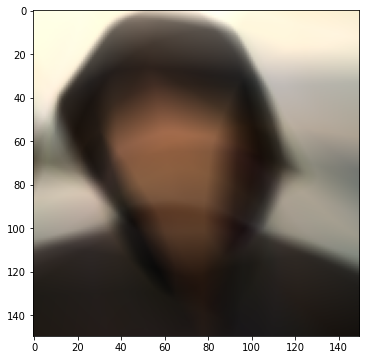

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(y_predicted_retransformed)
plt.show()

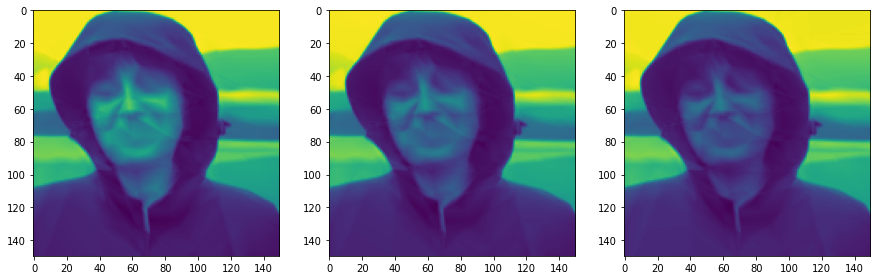

In [ ]:
# Triki Miki --------> R,G,B

r_pred = y_predicted_retransformed[:,:,0]
g_pred = y_predicted_retransformed[:,:,1]
b_pred = y_predicted_retransformed[:,:,2]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax[0].imshow(r_pred)
ax[1].imshow(g_pred)
ax[2].imshow(b_pred)
plt.show()

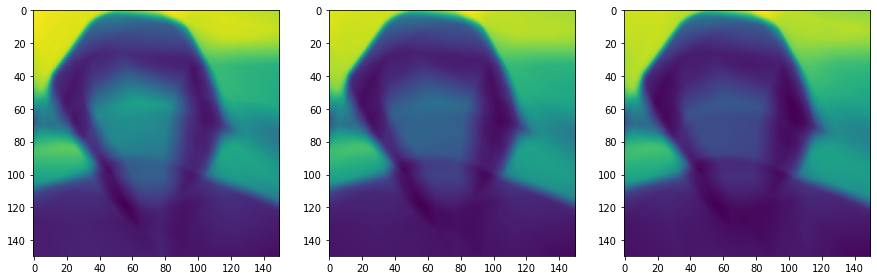

In [ ]:
# Triki Miki --------> R,G,B

r_pred = y_predicted_retransformed[:,:,0]
g_pred = y_predicted_retransformed[:,:,1]
b_pred = y_predicted_retransformed[:,:,2]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax[0].imshow(r_pred)
ax[1].imshow(g_pred)
ax[2].imshow(b_pred)
plt.show()

## Na jó

Akkor próbálkozzunk valami egyszerűbbel - Multioutput

In [ ]:
from sklearn.datasets import make_regression
import numpy as np
import matplotlib.pyplot as plt


# create dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, n_targets=3, random_state=2)

_x = np.linspace(0, 100, 1000)
print(_x.shape)
_x0 = np.sin(_x/12)
_x1 = np.sin(_x/20)
_x2 = np.sin(_x/30)
_x3 = np.sin(_x/40)
_x4 = np.sin(_x/50)
_x5 = np.sin(_x/60)
_x6 = np.sin(_x/70)
_x7 = np.sin(_x/80)
_x8 = np.sin(_x/90)
_x9 = np.sin(_x/95)

_y0 = (_x0 + _x1 + _x2 + _x3)
_y1 = (_x0 + _x5)
_y2 = (_x5 + _x6 + _x7 + _x8 + _x9)

y = np.array([_y0, _y1, _y2]).T
X = np.array([_x0, _x1, _x2, _x3, _x4, _x5, _x6, _x7, _x8, _x9]).T

# summarize shape
print(X.shape, y.shape)

(1000,)
(1000, 10) (1000, 3)


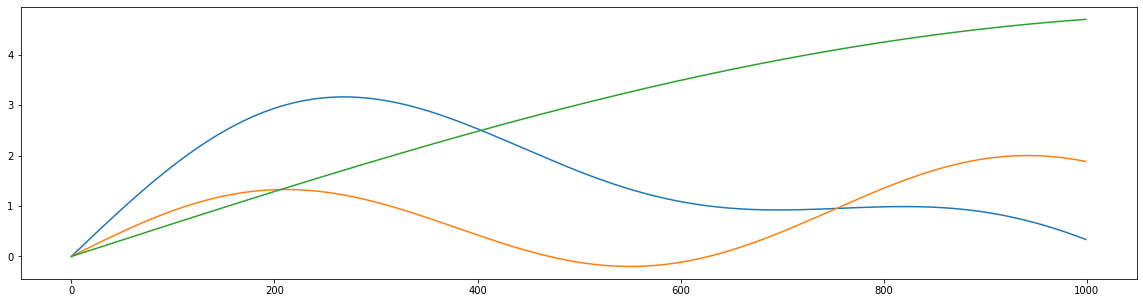

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(y[:,0])
plt.plot(y[:,1])
plt.plot(y[:,2])
plt.show()

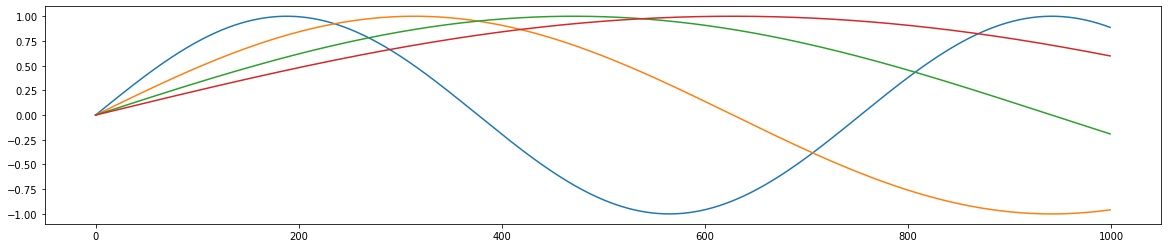

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(X[:,0])
plt.plot(X[:,1])
plt.plot(X[:,2])
plt.plot(X[:,3])
plt.show()

In [ ]:
import keras

# define the model
model = keras.Sequential()
model.add(keras.layers.Dense(20, input_dim=10, kernel_initializer='he_uniform', activation='relu'))
model.add(keras.layers.Dense(3))
model.compile(loss='mae', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                220       
                                                                 
 dense_1 (Dense)             (None, 3)                 63        
                                                                 
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def get_model(n_inputs, n_outputs):
	model = keras.Sequential()
	model.add(keras.layers.Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
	model.add(keras.layers.Dense(n_outputs))
	model.compile(loss='mae', optimizer='adam')
 
	return model

In [ ]:
# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
  n_inputs, n_outputs = X.shape[1], y.shape[1]
  # define model
  model = get_model(n_inputs, n_outputs)
  # fit model
  history = model.fit(X, y, verbose=0, epochs=100)
  # evaluate model on test set
  mae = model.evaluate(X, y, verbose=0)
  # store result
  print('>%.3f' % mae)

  #model.predict

  return model

In [ ]:
trained_model = evaluate_model(X,y)

>0.004


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  # plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

In [ ]:
plot_loss(history)

In [ ]:
y_predicted = trained_model.predict(X)

In [ ]:
x = tf.linspace(0.0, 150, 151)
y_predicted = single_feature_model.predict(x)

def plot_input_prediction_predicted(x, y_predicted):
  plt.scatter(input_feature, output_variable, label='Data')
  plt.plot(x, y_predicted, color='k', label='Predictions')
  plt.xlabel('input_feature {x_cols_width}')
  plt.ylabel('gray image pixel intesity')
  plt.legend()

(1000, 3)


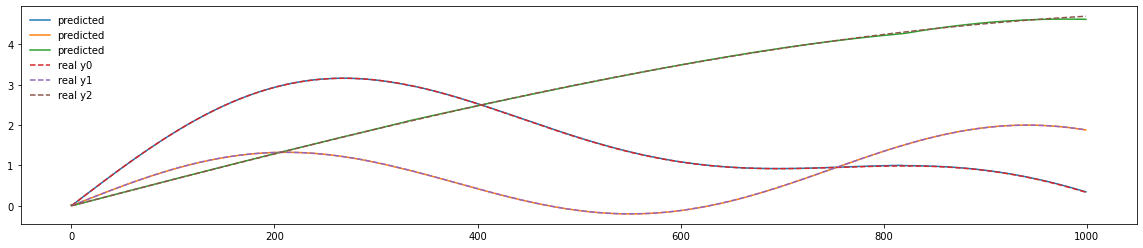

In [ ]:
print(y_predicted.shape)

plt.figure(figsize=(20, 4))
plt.plot(y_predicted, label='predicted')
plt.plot(y[:,0], linestyle='dashed', label='real y0')
plt.plot(y[:,1], linestyle='dashed', label='real y1')
plt.plot(y[:,2], linestyle='dashed', label='real y2')
plt.legend(frameon = False)
plt.show()